In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys

In [2]:
test_data = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\UNSW_NB15_testing-set.csv")
train_data = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\UNSW_NB15_training-set.csv")

In [3]:
len(train_data["proto"].unique()), len(test_data["proto"].unique())

(133, 131)

In [4]:
columns_numeric = train_data.select_dtypes(include="number").drop(columns="id").columns

In [5]:
len(columns_numeric)

40

In [6]:
columns_numeric = [
    col for col in columns_numeric
    if not len(train_data[col].value_counts()) < 3
]

In [7]:
len(columns_numeric)

38

In [8]:
train_data.set_index("id", inplace=True)

In [9]:
test_data.set_index("id", inplace=True)

In [10]:
pd.set_option('display.max_columns', 120)
train_data.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.2956,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.0,0.0,0.0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.9150,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.0,0.0,0.0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0


# Data Preprocessing

## Outlier Treatment

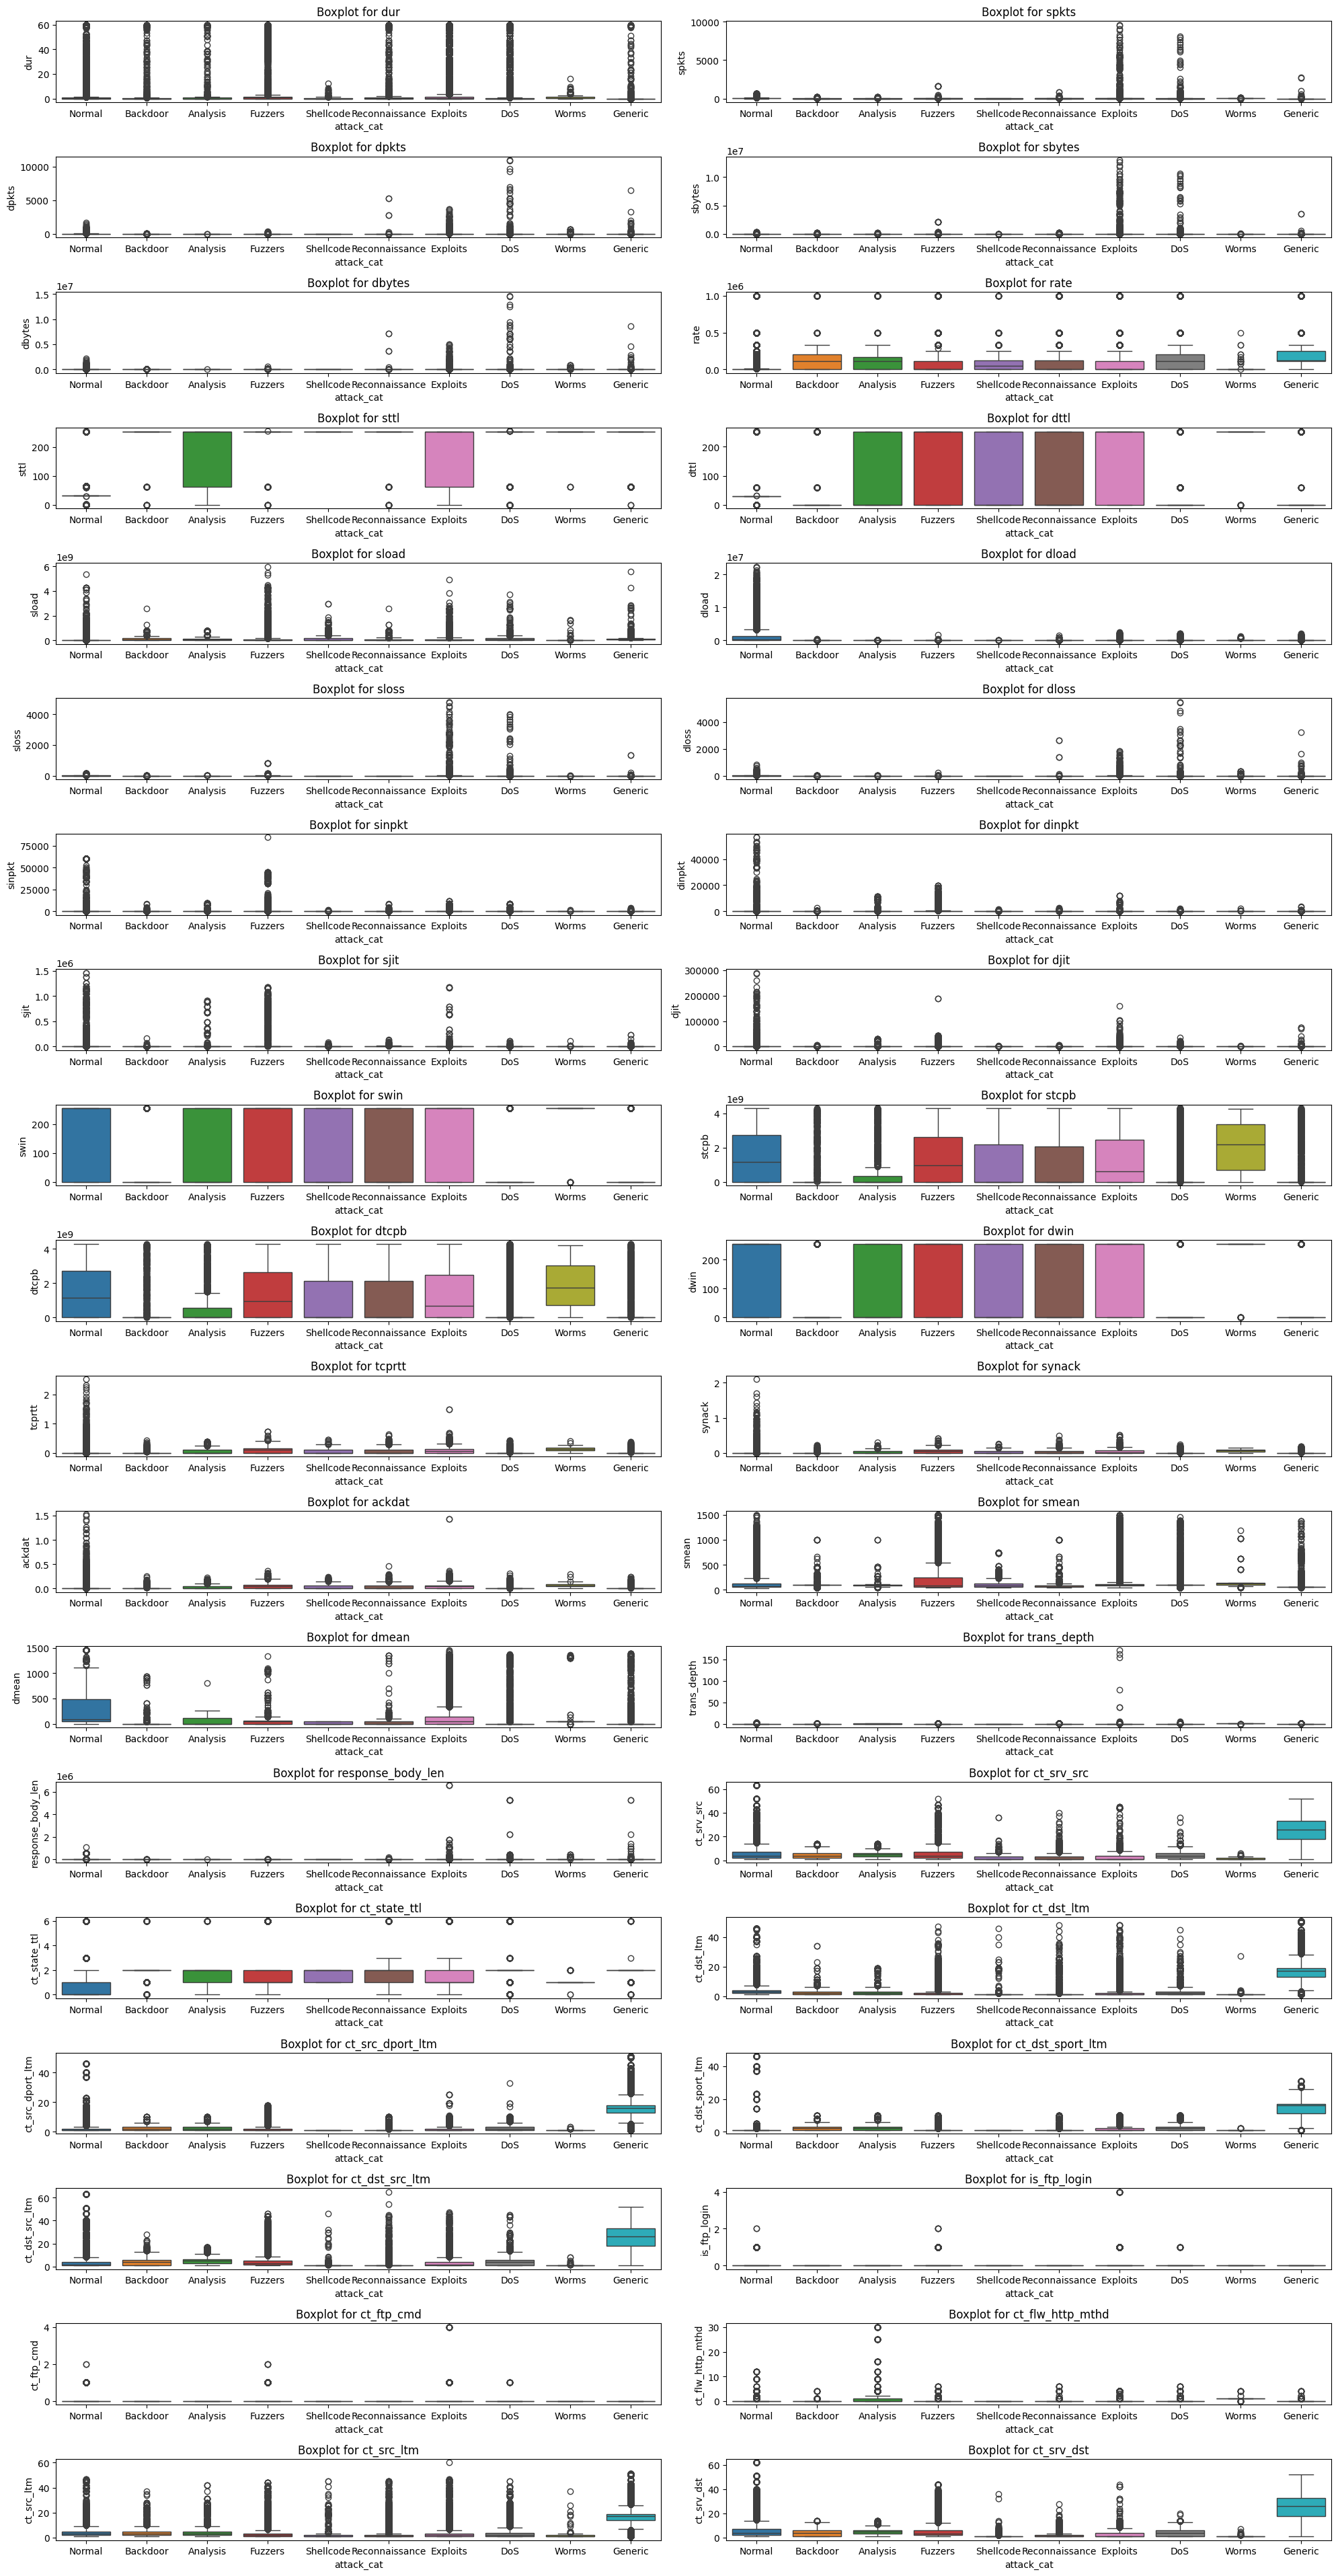

In [11]:
fig, axes = plt.subplots(20,2, figsize=(20,40), tight_layout=True)
axes = axes.flatten()

for col,ax in zip(columns_numeric, axes):
    g = sns.boxplot(data = train_data, y = col, x = train_data["attack_cat"],hue = train_data["attack_cat"], ax = ax)
    g.set_title(f"Boxplot for {col}")
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

plt.show()
    

In [ ]:
import numpy as np

def estimate_contamination_iqr(data, columns_numeric):
    """
    Estimate a reasonable contamination value based on IQR.
    """
    contamination_rates = []
    for col in columns_numeric:
        q1 = np.percentile(data[col], 25)
        q3 = np.percentile(data[col], 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Count outliers
        num_outliers = np.sum((data[col] < lower_bound) | (data[col] > upper_bound))
        contamination_rates.append(num_outliers / len(data))

    return np.mean(contamination_rates)  # Average contamination rate across all numeric columns

# Example usage
estimated_contamination = estimate_contamination_iqr(train_data, columns_numeric)
print(f"Estimated contamination: {estimated_contamination:.3f}")


In [12]:
from sklearn.ensemble import IsolationForest

class OutlierIsolationForest:
    def __init__(self, contamination=0.05, random_state=42):
        """
        Initialize the Isolation Forest for outlier detection.

        Parameters:
        - contamination (float): The proportion of data points to be considered as outliers.
        - random_state (int): Random seed for reproducibility.
        """
        self.contamination = contamination
        self.random_state = random_state
        self.iso_forest = None

    def fit(self, dataframe, columns_numeric):
        """
        Fit the Isolation Forest model on the numeric features to detect outliers.

        Parameters:
        - dataframe (pd.DataFrame): The dataset containing numeric features.
        - columns_numeric (list): List of numeric columns to process.
        """
        print("Fitting Isolation Forest for outlier detection...")

        # Ensure numeric columns are float type
        dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

        # Initialize and fit Isolation Forest
        self.iso_forest = IsolationForest(contamination=self.contamination, random_state=self.random_state)
        self.iso_forest.fit(dataframe[columns_numeric])

        print("Fitting completed.")

    def transform(self, dataframe, columns_numeric):
        """
        Apply Isolation Forest to remove detected outliers.

        Parameters:
        - dataframe (pd.DataFrame): The dataset to process.
        - columns_numeric (list): List of numeric columns to process.

        Returns:
        - pd.DataFrame: The cleaned dataset without outliers.
        """
        print("Applying Isolation Forest for outlier removal...")

        # Ensure numeric columns are float type
        dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

        # Predict outliers (-1 indicates an outlier, 1 indicates normal data)
        outlier_predictions = self.iso_forest.predict(dataframe[columns_numeric])
        
        # Keep only non-outliers
        dataframe_cleaned = dataframe[outlier_predictions == 1].reset_index(drop=True)

        print(f"Outliers removed: {len(dataframe) - len(dataframe_cleaned)}")
        return dataframe_cleaned

In [13]:
iso_forest_outlier = OutlierIsolationForest(contamination=0.1)  # Adjust contamination as needed
iso_forest_outlier.fit(train_data, columns_numeric)
train_data = iso_forest_outlier.transform(train_data, columns_numeric)
test_data = iso_forest_outlier.transform(test_data, columns_numeric)

Fitting Isolation Forest for outlier detection...
Fitting completed.
Applying Isolation Forest for outlier removal...
Outliers removed: 17533
Applying Isolation Forest for outlier removal...
Outliers removed: 9164


In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class OutlierKNN:
    def __init__(self, n_neighbors=5):
        """
        Initialize the OutlierTreatment class, which stores IQR bounds.
        The outliers will be imputed after scaling and normalization using KNNImputer.
        """
        self.iqr_bounds = {}  # Store IQR bounds for each column
        self.scaler = None  # Store StandardScaler
        self.minmax_scaler = None  # Store MinMaxScaler
        self.knn_imputer = KNNImputer(n_neighbors=n_neighbors)  # KNN Imputer

    def fit(self, dataframe, columns_numeric):
        """
        Compute IQR bounds and fit scalers and imputer on training data only.
        """
        print("Fitting outlier treatment...")

        dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

        # Compute IQR bounds
        for col in columns_numeric:
            q1 = dataframe[col].quantile(0.25)
            q3 = dataframe[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            self.iqr_bounds[col] = (lower_bound, upper_bound)

        # Replace outliers with NaN to be imputed
        for col in columns_numeric:
            lower_bound, upper_bound = self.iqr_bounds[col]
            outliers = (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)
            dataframe.loc[outliers, col] = np.nan

        # Fit StandardScaler and MinMaxScaler
        self.scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler()

        dataframe_scaled = self.scaler.fit_transform(dataframe[columns_numeric])
        dataframe_scaled = self.minmax_scaler.fit_transform(dataframe_scaled)

        # Fit KNN Imputer on scaled data
        self.knn_imputer.fit(dataframe_scaled)

        print("Fitting completed.")

    def transform(self, dataframe, columns_numeric):
        """
        Apply outlier treatment using precomputed IQR bounds, scaling, normalization, and KNN imputation.
        """
        print("Transforming data...")

        dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

        # Replace outliers with NaN to be imputed
        for col in columns_numeric:
            lower_bound, upper_bound = self.iqr_bounds[col]
            outliers = (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)
            dataframe.loc[outliers, col] = np.nan

        # Apply scaling and normalization
        dataframe_scaled = self.scaler.transform(dataframe[columns_numeric])
        dataframe_scaled = self.minmax_scaler.transform(dataframe_scaled)

        # Apply KNN Imputation
        dataframe_imputed = self.knn_imputer.transform(dataframe_scaled)

        # Reverse scaling to restore original range
        dataframe_restored = self.scaler.inverse_transform(self.minmax_scaler.inverse_transform(dataframe_imputed))

        # Convert back to DataFrame
        dataframe[columns_numeric] = dataframe_restored

        print("Transformation completed.")
        return dataframe

In [15]:
#KNNOutlierApplier = OutlierKNN(n_neighbors=3)

#KNNOutlierApplier.fit(train_data,columns_numeric)

#train_data = KNNOutlierApplier.transform(train_data,columns_numeric)
#test_data = KNNOutlierApplier.transform(test_data, columns_numeric)

In [16]:
#class specific = PROBLEMATIC

def treat_outliers(dataframe, columns_numeric, isTest=False):
    """
    Treats outliers in the dataset for the specified numeric columns.

    On the training set:
        - Identifies outliers using the IQR method for each column grouped by "attack_cat".
        - Replaces outliers with the mean value of the column grouped by "attack_cat".
        - Stores the IQR bounds for each column and class.

    On the test set:
        - Uses the stored IQR bounds from training for each column and class.
        - Replaces outliers with the mean value of the column grouped by "attack_cat".

    Parameters:
        dataframe (pd.DataFrame): The dataset to process.
        columns_numeric (list): List of numeric columns to focus on for outlier treatment.
        isTest (bool): Whether the function is applied to the test set.

    Returns:
        pd.DataFrame: The processed dataset with outliers treated.
    """
    
    if not hasattr(treat_outliers, "iqr_bounds"):
        treat_outliers.iqr_bounds = {}  # Store IQR bounds for training (keyed by column and class)

    if isTest and not treat_outliers.iqr_bounds:
        raise ValueError("IQR bounds are not set. Train the function on the training data first.")

    print("Treating outliers...")
    
    # Ensure all numeric columns are cast to float to handle outliers consistently
    dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

    # Process each numeric column
    for col in columns_numeric:
        if not isTest:
            # Initialize dictionary for column if not already present
            treat_outliers.iqr_bounds[col] = {}

            # Group by "attack_cat" to calculate class-specific IQR bounds
            for attack_cat, group in dataframe.groupby("attack_cat"):
                q1 = group[col].quantile(0.25)
                q3 = group[col].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                treat_outliers.iqr_bounds[col][attack_cat] = (lower_bound, upper_bound)

                # Identify outliers for this class
                outliers = (group[col] < lower_bound) | (group[col] > upper_bound)

                # Replace outliers with the class mean
                replacement_mean = group[col].mean()
                dataframe.loc[group[outliers].index, col] = replacement_mean
        else:
            # Use stored IQR bounds for test set
            for attack_cat, bounds in treat_outliers.iqr_bounds[col].items():
                lower_bound, upper_bound = bounds
        
                # Get test data rows for this attack_cat
                class_rows = dataframe[dataframe["attack_cat"] == attack_cat]
        
                # Identify outliers
                outliers = (class_rows[col] < lower_bound) | (class_rows[col] > upper_bound)
        
                # Replace outliers with the training class mean
                replacement_mean = dataframe[dataframe["attack_cat"] == attack_cat][col].mean()
                dataframe.loc[class_rows[outliers].index, col] = replacement_mean


    print("Outlier treatment completed.")
    return dataframe


In [17]:
import pandas as pd
from sklearn.impute import SimpleImputer

class OutlierTreatment:
    def __init__(self, strategy="mean"):
        """
        Initialize the OutlierTreatment class, which stores IQR bounds and global means/medians from training.
        """
        self.iqr_bounds = {}  # Store IQR bounds for each column
        self.global_imputer = None  # Store imputer for handling outliers

        if strategy not in ["mean", "median"]:
            raise ValueError("Invalid strategy. Use 'mean' or 'median'.")
        self.strategy = strategy

    def fit(self, dataframe, columns_numeric):
        """
        Compute IQR bounds and global statistics (mean/median) from training data only.
        """
        print("Fitting outlier treatment...")

        dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

        self.global_imputer = SimpleImputer(strategy=self.strategy)
        self.global_imputer.fit(dataframe[columns_numeric])  # Fit global imputer

        for col in columns_numeric:
            q1 = dataframe[col].quantile(0.25)
            q3 = dataframe[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            self.iqr_bounds[col] = (lower_bound, upper_bound)

        print("Fitting completed.")

    def transform(self, dataframe, columns_numeric):
        """
        Apply outlier treatment using precomputed IQR bounds and global imputation.
        """
        print("Transforming data...")

        dataframe[columns_numeric] = dataframe[columns_numeric].astype(float)

        for col in columns_numeric:
            if col not in self.iqr_bounds:
                raise ValueError(f"IQR bounds for column '{col}' are not set. Ensure you fit on training data first.")

            lower_bound, upper_bound = self.iqr_bounds[col]
            outliers = (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)

            # Replace outliers with NaN to be imputed
            dataframe.loc[outliers, col] = np.nan

        # Apply global imputation
        dataframe[columns_numeric] = self.global_imputer.transform(dataframe[columns_numeric])

        print("Transformation completed.")
        return dataframe


In [18]:
#train_data = treat_outliers(train_data, columns_numeric)
#test_data = treat_outliers(test_data, columns_numeric, isTest=True)

In [19]:
#outlierhandler = OutlierTreatment(strategy = "median")
#outlierhandler.fit(train_data,columns_numeric)
#train_data = outlierhandler.transform(train_data,columns_numeric)
#test_data = outlierhandler.transform(test_data,columns_numeric)



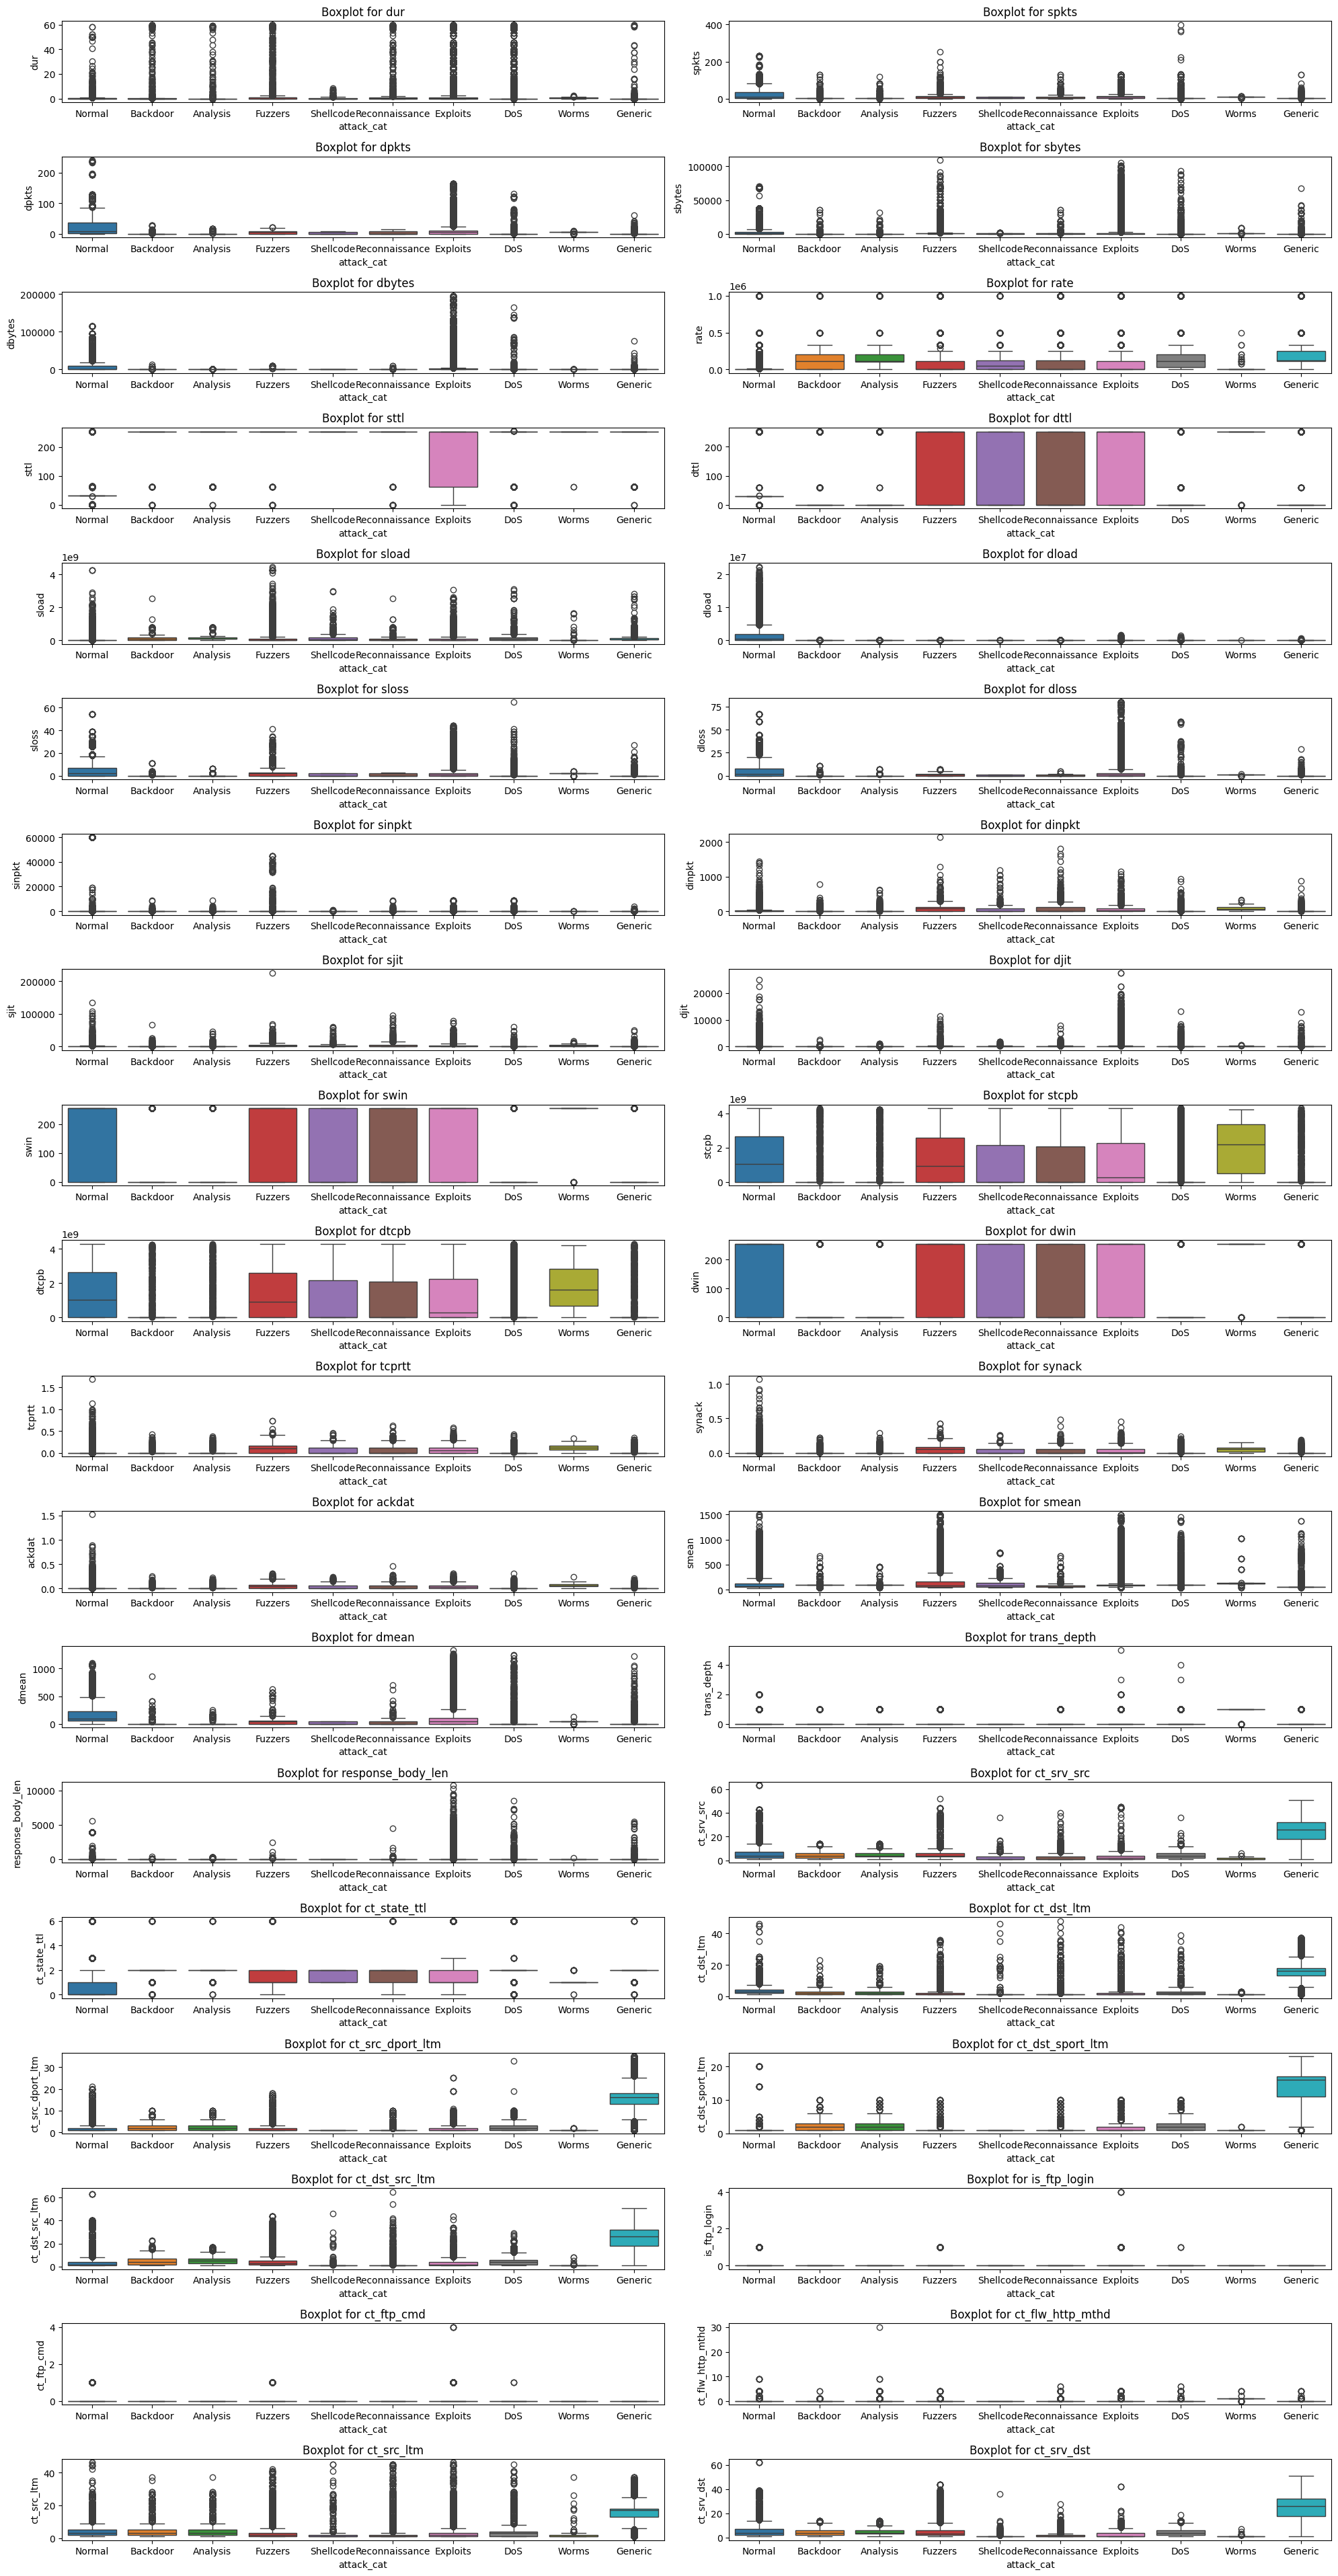

In [20]:
fig, axes = plt.subplots(20,2, figsize=(20,40), tight_layout=True)
axes = axes.flatten()

for col,ax in zip(columns_numeric, axes):
    g = sns.boxplot(data = train_data, y = col, x = train_data["attack_cat"],hue = train_data["attack_cat"], ax = ax)
    g.set_title(f"Boxplot for {col}")
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

plt.show()

A lot more quantiles are displayed now !!

In [21]:
train_cat = train_data.select_dtypes(exclude=[np.number])
train_cat.describe(include='all')

,proto,service,state,attack_cat
count,157808,157808,157808,157808
unique,133,13,9,10
top,tcp,-,INT,Normal
freq,66779,88304,78734,48932


In [22]:
# Function to reduce categories in categorical columns while preserving the target column
def reduce_categories(train_data, test_data, target_column, threshold=6, debug=False):
    # Select categorical columns in train and test data, excluding the target column
    train_cat = train_data.select_dtypes(exclude=[np.number]).drop(columns=[target_column], errors='ignore')
    test_cat = test_data.select_dtypes(exclude=[np.number]).drop(columns=[target_column], errors='ignore')
    
    # Iterate through categorical columns
    for feature in train_cat.columns:
        if debug:
            print(f"Processing feature: {feature}")
            print(f"Number of unique categories before reduction: {train_cat[feature].nunique()}")
            print('----------------------------------------------------')
        
        # Check if the number of unique categories exceeds the threshold
        if train_cat[feature].nunique() > threshold:
            # Identify the top categories in the train set
            top_categories = train_data[feature].value_counts().head(threshold).index
            
            # Reduce train and test data to these top categories, replacing others with '-'
            train_data[feature] = np.where(train_data[feature].isin(top_categories), train_data[feature], '-')
            test_data[feature] = np.where(test_data[feature].isin(top_categories), test_data[feature], '-')
    
    # Return the modified train and test datasets
    return train_data, test_data

# Apply the function to your train and test datasets
train_data, test_data = reduce_categories(train_data, test_data, target_column='attack_cat', threshold=6, debug=False)

# Check the resulting categorical columns
train_cat = train_data.select_dtypes(exclude=[np.number])
test_cat = test_data.select_dtypes(exclude=[np.number])

print("Train categorical summary after reduction:")
print(train_cat.describe(include='all'))

print("\nTest categorical summary after reduction:")
print(test_cat.describe(include='all'))

Train categorical summary after reduction:
         proto service   state attack_cat
count   157808  157808  157808     157808
unique       7       6       7         10
top        tcp       -     INT     Normal
freq     66779   90636   78734      48932

Test categorical summary after reduction:
        proto service  state attack_cat
count   73168   73168  73168      73168
unique      7       6      6         10
top       tcp       -    FIN     Normal
freq    37141   44551  34461      32829


## Normalizing and Scaling

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [24]:
numeric = train_data.select_dtypes(include="number").columns

normalizer = MinMaxScaler().set_output(transform="pandas")
scaler = StandardScaler().set_output(transform="pandas")
r_scaler = RobustScaler().set_output(transform="pandas")

train_data[numeric] = r_scaler.fit_transform(train_data[numeric])
test_data[numeric] = r_scaler.transform(test_data[numeric])

train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.transform(test_data[numeric])

train_data[numeric] = normalizer.fit_transform(train_data[numeric])
test_data[numeric] = normalizer.transform(test_data[numeric])

In [25]:
train_data.shape, test_data.shape

((157808, 44), (73168, 44))

In [26]:
len(train_data["state"].unique()), len(test_data["state"].unique())

(7, 6)

## Treating Skewness

In [27]:
import pandas as pd
import numpy as np

# Set skewness threshold (e.g., |skewness| > 1 is considered highly skewed)
skew_threshold = 1

numeric_cols = train_data.select_dtypes(include = "number").columns

# Select numeric columns
# Calculate skewness for numeric columns
skewness = train_data[numeric_cols].skew()

# Identify columns with skewness above the threshold
skewed_cols = skewness[skewness.abs() > skew_threshold].index
print("Skewed columns:", skewed_cols)

# Apply log transformation to skewed columns
for col in skewed_cols:
    # Add 1 to avoid issues with log(0)
    train_data[col] = np.log1p(train_data[col])
    test_data[col] = np.log1p(test_data[col])  # Apply same transformation to test data


Skewed columns: Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')


# Feature Engineering

## OneHotEncoding

In [28]:
# Separate features and labels
train_data_X = train_data.drop(columns=["attack_cat", "label"])
train_data_y = train_data[["attack_cat", "label"]]

test_data_X = test_data.drop(columns=["attack_cat", "label"])
test_data_y = test_data[["attack_cat", "label"]]

# Identify categorical columns
categorical_cols = train_data_X.select_dtypes(include="object").columns
print(categorical_cols)  # Verify the categorical columns

# Use OneHotEncoder with handle_unknown='ignore' to ensure consistency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define and fit the encoder on training data
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')  # Drop first category to avoid dummy variable trap
ct = ColumnTransformer(transformers=[('encoder', encoder, categorical_cols)], remainder='passthrough')

# Fit the encoder on train data
train_data_X_encoded = ct.fit_transform(train_data_X)

# Transform the test data using the same encoder
test_data_X_encoded = ct.transform(test_data_X)

# Convert the encoded data back to DataFrame for alignment
import pandas as pd
train_data_X_encoded = pd.DataFrame(train_data_X_encoded, columns=ct.get_feature_names_out(), index=train_data_X.index)
test_data_X_encoded = pd.DataFrame(test_data_X_encoded, columns=ct.get_feature_names_out(), index=test_data_X.index)

# Ensure consistent columns between train and test
train_data_X, test_data_X = train_data_X_encoded.align(test_data_X_encoded, join="outer", axis=1, fill_value=0)

Index(['proto', 'service', 'state'], dtype='object')


In [29]:
for index, column_name in enumerate(test_data_X.columns):
    print(index, column_name)

0 encoder__proto_arp
1 encoder__proto_ospf
2 encoder__proto_sctp
3 encoder__proto_tcp
4 encoder__proto_udp
5 encoder__proto_unas
6 encoder__service_dns
7 encoder__service_ftp
8 encoder__service_ftp-data
9 encoder__service_http
10 encoder__service_smtp
11 encoder__state_CON
12 encoder__state_ECO
13 encoder__state_FIN
14 encoder__state_INT
15 encoder__state_REQ
16 encoder__state_RST
17 remainder__dur
18 remainder__spkts
19 remainder__dpkts
20 remainder__sbytes
21 remainder__dbytes
22 remainder__rate
23 remainder__sttl
24 remainder__dttl
25 remainder__sload
26 remainder__dload
27 remainder__sloss
28 remainder__dloss
29 remainder__sinpkt
30 remainder__dinpkt
31 remainder__sjit
32 remainder__djit
33 remainder__swin
34 remainder__stcpb
35 remainder__dtcpb
36 remainder__dwin
37 remainder__tcprtt
38 remainder__synack
39 remainder__ackdat
40 remainder__smean
41 remainder__dmean
42 remainder__trans_depth
43 remainder__response_body_len
44 remainder__ct_srv_src
45 remainder__ct_state_ttl
46 remai

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Ensure you work with copies of the DataFrames
train_data_X = train_data_X.copy()
test_data_X = test_data_X.copy()

# Filter only numeric columns for scaling
numeric_cols_train = train_data_X.select_dtypes(include=['number']).columns
numeric_cols_test = test_data_X.select_dtypes(include=['number']).columns

# Ensure numeric columns are cast to float before scaling
train_data_X[numeric_cols_train] = train_data_X[numeric_cols_train].astype(float)
test_data_X[numeric_cols_test] = test_data_X[numeric_cols_test].astype(float)

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler to train_data
train_data_scaled = standard_scaler.fit_transform(train_data_X[numeric_cols_train])
train_data_X.loc[:, numeric_cols_train] = train_data_scaled

# Apply StandardScaler to test_data
test_data_scaled = standard_scaler.transform(test_data_X[numeric_cols_test])
test_data_X.loc[:, numeric_cols_test] = test_data_scaled

# Apply MinMaxScaler to train_data
train_data_scaled = minmax_scaler.fit_transform(train_data_X[numeric_cols_train])
train_data_X.loc[:, numeric_cols_train] = train_data_scaled

# Apply MinMaxScaler to test_data
test_data_scaled = minmax_scaler.transform(test_data_X[numeric_cols_test])
test_data_X.loc[:, numeric_cols_test] = test_data_scaled


### Converting data to required format

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data_X = pd.DataFrame(scaler.fit_transform(train_data_X), columns=train_data_X.columns)
test_data_X = pd.DataFrame(scaler.transform(test_data_X), columns=test_data_X.columns)

In [32]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = pd.DataFrame(label_encoder.fit_transform(train_data_y["attack_cat"]))
test_labels_encoded = pd.DataFrame(label_encoder.transform(test_data_y["attack_cat"]))

In [33]:
train_data_X.to_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_X_data.csv", index=False)
test_data_X.to_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_X_data.csv", index=False)
train_labels_encoded.to_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_y_data.csv", index=False)
test_labels_encoded.to_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_y_data.csv", index=False)

In [34]:
original_class_labels = label_encoder.classes_

import pickle
from sklearn.preprocessing import LabelEncoder

# Save the LabelEncoder object to a file
with open(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)